In [ ]:
!pip install openai-agents -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.9/116.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.3/129.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.4/100.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.9 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')

import os
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [ ]:
from datetime import datetime, timedelta

print(datetime.now().strftime("%Y-%m-%d"))
(datetime.now() - timedelta(1)).strftime("%Y-%m-%d")

2025-05-08


'2025-05-07'

In [ ]:
import nest_asyncio
nest_asyncio.apply()

from agents import Agent, Runner, WebSearchTool, trace, ItemHelpers, TResponseInputItem
from dataclasses import dataclass
from typing import Literal

In [ ]:
import asyncio

# Evaluator-Optimizer Multi-Agent System (LLM-as-a-Judge)

In [ ]:



today_date = datetime.now().strftime("%Y-%m-%d")
yesterday_date = (datetime.now() - timedelta(1)).strftime("%Y-%m-%d")
two_days_ago = (datetime.now() - timedelta(2)).strftime("%Y-%m-%d")

INSTRUCTIONS_NEWS_SEARCH = (
    "You are a research news assistant specialized in Finance or any news that can have impact on a financial health of a given company or a region."
    "You search the web for a given region to collect the most important and recent news. "
    "Produce a concise summary of the results with citations. The summary must 2-3 paragraphs and less than 300 words."
    "Capture the main points. Write succinctly."
    f"Get only the very latest news between 2 days ago {two_days_ago} and today {today_date}."
    "Use only this resource: https://www.reuters.com/world/europe/."
    "For each item you are providing, specify the date on which the article was published."
    "For each item you are providing, specify the complete external link to the article."
    "This is important. Otherwise, don't give me a summary, if you don't provide a date and an external link."
    "If you don't give a source link, it means that you are hallucinating."
)

web_news_searcher = Agent(
        name="web_news_searcher",
        instructions=INSTRUCTIONS_NEWS_SEARCH,
        tools=[WebSearchTool()],
    )

@dataclass
class EvaluationFeedback:
    feedback: str
    score: Literal["successful", "needs_links"]

news_evaluator = Agent(
    name="news_evaluator",
    instructions=(
        "You will be given a financial news summary in a given region (Euro, US, Asia) and you are asked to evaluate the completeness of external source links."
        "Check whether the news summary is supported by external article links."
        "If the user requested n news items, each item must be supported by an external source link, so you need to ensure that there are n source links."
        "External links are required for the user to verify the accuracy of the news."
    ),
    output_type=EvaluationFeedback,
)

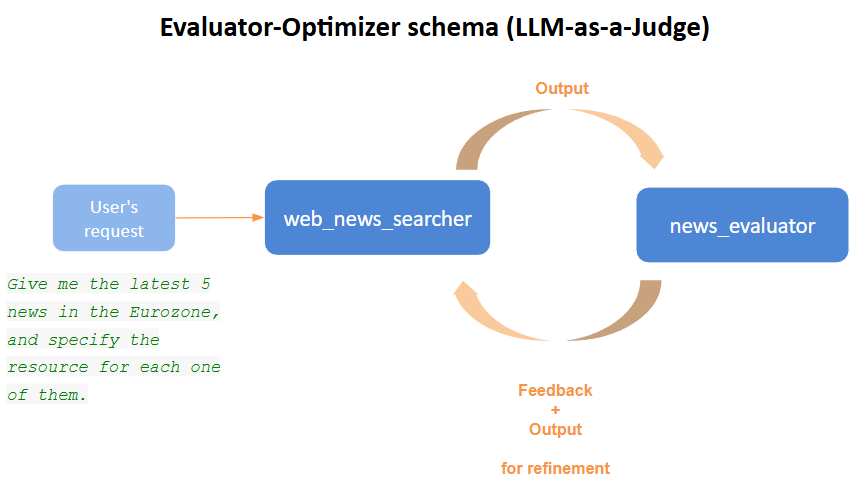

In [6]:
from IPython.display import Image, display
path_image = path + "web_news_searcher_BOT.png"
display(Image(filename=path_image))

# Chat with the Mutli-Agent System

## Give me the latest 5 news in Euro zone, and specify the resource for each one of them.

In [ ]:
async def main() -> None:
    msg = input("User's request:")
    input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    latest_outline: str | None = None

    max_iteration = 2

    # We'll run the entire workflow in a single trace
    nbr_iterations = 0
    while True:
        news_searcher_result = await Runner.run(
            web_news_searcher,
            input_items,
          )

        input_items = news_searcher_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(news_searcher_result.new_items)
        # final_output_generator = news_searcher_result.final_output #same than latest_outline

        print("\033[92m**************************NEWS SEARCH:**************************\033[0m")
        print(latest_outline)

        print("\n\n\033[92m**************************Running Evaluation:**************************\033[0m")
        news_evaluator_result = await Runner.run(news_evaluator, latest_outline)
        result: EvaluationFeedback = news_evaluator_result.final_output

        print(f"\033[94mEvaluator score: {result.score}\033[0m")
        print("\n")

        if result.score == "successful":
              print("\033[92m Links check is good ==> stopping the iteration.\033[0m")
              break

        print("\033[94mFeedback:\033[0m")
        print(result.feedback)

        print("\n\n\033[92m**************************Running Refinement:**************************\033[0m")
        print("\033[94mRe-running with feedback for improvements:\033[0m")
        input_items.append({"content": f"News Summary: {latest_outline}", "role": "system"})
        input_items.append({"content": f"Feedback: {result.feedback}\n for each item in the news summary, provide an external source link:", "role": "user"})
        # input_items.append({"content": f"Feedback: {result.feedback}", "role": "user"})
        nbr_iterations+=1

        if nbr_iterations>max_iteration:
              print("\033[91mReached max_iteration ==> stopping the iteration.\033[0m")
              break

    print("\n\n\033[92m**************************Final Set of News with Links:**************************\033[0m")
    print(latest_outline)


if __name__ == "__main__":
    asyncio.run(main())

# Give me the latest 5 news in Euro zone, and specify the resource for each one of them.

User's request:Give me the latest 5 news in Euro zone, and specify the resource for each one of them.
**************************NEWS SEARCH:**************************
As of May 8, 2025, there are no new articles available from Reuters' Europe section covering the Euro zone within the past two days. The most recent relevant article was published on December 18, 2024, discussing the European Commission's recommendation for slight fiscal tightening in the Euro zone for 2025 and 2026. ([reuters.com](https://www.reuters.com/markets/europe/eu-commission-recommends-slight-euro-zone-fiscal-tightening-2025-2026-2024-12-18/?utm_source=openai))

For the latest updates on the Euro zone, you may consider checking other reputable news sources or financial news platforms. 


**************************Running Evaluation:**************************
Evaluator score: needs_links


Feedback:
The summary only contains one external source link for a past article, and does not include links for five news item

## Same query again to check if I get persistant answers

In [ ]:
async def main() -> None:
    msg = input("User's request:")
    input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    latest_outline: str | None = None

    max_iteration = 2

    # We'll run the entire workflow in a single trace
    nbr_iterations = 0
    while True:
        news_searcher_result = await Runner.run(
            web_news_searcher,
            input_items,
          )

        input_items = news_searcher_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(news_searcher_result.new_items)
        # final_output_generator = news_searcher_result.final_output #same than latest_outline

        print("\033[92m**************************NEWS SEARCH:**************************\033[0m")
        print(latest_outline)

        print("\n\n\033[92m**************************Running Evaluation:**************************\033[0m")
        news_evaluator_result = await Runner.run(news_evaluator, latest_outline)
        result: EvaluationFeedback = news_evaluator_result.final_output

        print(f"\033[94mEvaluator score: {result.score}\033[0m")
        print("\n")

        if result.score == "successful":
              print("\033[92m Links check is good ==> stopping the iteration.\033[0m")
              break

        print("\033[94mFeedback:\033[0m")
        print(result.feedback)

        print("\n\n\033[92m**************************Running Refinement:**************************\033[0m")
        print("\033[94mRe-running with feedback for improvements:\033[0m")
        input_items.append({"content": f"News Summary: {latest_outline}", "role": "system"})
        input_items.append({"content": f"Feedback: {result.feedback}\n for each item in the news summary, provide an external source link:", "role": "user"})
        # input_items.append({"content": f"Feedback: {result.feedback}", "role": "user"})
        nbr_iterations+=1

        if nbr_iterations>max_iteration:
              print("\033[91mReached max_iteration ==> stopping the iteration.\033[0m")
              break

    print("\n\n\033[92m**************************Final Set of News with Links:**************************\033[0m")
    print(latest_outline)


if __name__ == "__main__":
    asyncio.run(main())

# Give me the latest 5 news in Euro zone, and specify the resource for each one of them.

User's request:Give me the latest 5 news in Euro zone, and specify the resource for each one of them.
**************************NEWS SEARCH:**************************
Here are the latest five news items concerning the Euro zone:

1. **EU Discusses Sanctions Over Russia's Alleged Chemical Weapons Use**  
   On May 7, 2025, the European Commission proposed adding 15 entities and individuals to its sanctions list, targeting those involved in Russia's hybrid threats and suspected use of chemical weapons in Ukraine. This move follows reports from the Organisation for the Prohibition of Chemical Weapons (OPCW) indicating evidence of tear gas use on the Ukrainian frontline, a violation under the Chemical Weapons Convention if used in warfare. ([reuters.com](https://www.reuters.com/world/europe/eu-envoys-discuss-sanctions-related-russia-chemical-weapons-use-2025-05-07/?utm_source=openai))

2. **Germany's Chancellor Urges EU Allies to Boost Defense Spending**  
   During his inaugural foreign v

## Give me the latest news for 2 regions: Eurozone and US

In [ ]:
async def main() -> None:
    msg = input("User's request:")
    input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    latest_outline: str | None = None

    max_iteration = 2

    # We'll run the entire workflow in a single trace
    nbr_iterations = 0
    while True:
        news_searcher_result = await Runner.run(
            web_news_searcher,
            input_items,
          )

        input_items = news_searcher_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(news_searcher_result.new_items)
        # final_output_generator = news_searcher_result.final_output #same than latest_outline

        print("\033[92m**************************NEWS SEARCH:**************************\033[0m")
        print(latest_outline)

        print("\n\n\033[92m**************************Running Evaluation:**************************\033[0m")
        news_evaluator_result = await Runner.run(news_evaluator, latest_outline)
        result: EvaluationFeedback = news_evaluator_result.final_output

        print(f"\033[94mEvaluator score: {result.score}\033[0m")
        print("\n")

        if result.score == "successful":
              print("\033[92m Links check is good ==> stopping the iteration.\033[0m")
              break

        print("\033[94mFeedback:\033[0m")
        print(result.feedback)

        print("\n\n\033[92m**************************Running Refinement:**************************\033[0m")
        print("\033[94mRe-running with feedback for improvements:\033[0m")
        input_items.append({"content": f"News Summary: {latest_outline}", "role": "system"})
        input_items.append({"content": f"Feedback: {result.feedback}\n for each item in the news summary, provide an external source link:", "role": "user"})
        # input_items.append({"content": f"Feedback: {result.feedback}", "role": "user"})
        nbr_iterations+=1

        if nbr_iterations>max_iteration:
              print("\033[91mReached max_iteration ==> stopping the iteration.\033[0m")
              break

    print("\n\n\033[92m**************************Final Set of News with Links:**************************\033[0m")
    print(latest_outline)


if __name__ == "__main__":
    asyncio.run(main())

# Give me the latest 5 news items for each region: Eurozone and US. Specify the source for each one, and organize the news into separate paragraphs by region.

User's request:Give me the latest 5 news items for each region: Eurozone and US. Specify the source for each one, and organize the news into separate paragraphs by region.
**************************NEWS SEARCH:**************************
**Eurozone:**

1. **European Central Bank (ECB) Considers Further Rate Cuts**  
   The ECB is debating whether to lower interest rates below the neutral level in its current easing cycle. Some policymakers believe that merely reaching the neutral rate may not suffice to stimulate the economy. ([fxstreet.com](https://www.fxstreet.com/news/ecb-starting-to-debate-whether-rates-need-to-go-below-neutral-in-latest-easing-cycle-reuters-202410230502?utm_source=openai))

2. **Eurozone Economy Shows Zero Growth in Q4 2024**  
   The eurozone economy stagnated in the fourth quarter of 2024, with zero growth reported, missing expectations for a slight expansion. This flatlining raises concerns about the region's economic momentum. ([nbcchicago.com](https://www.nbcc

# Add date of the article in the outpute

Only the instruction of the news_evaluator has been modified

In [ ]:
# today_date = datetime.now().strftime("%Y-%m-%d")
# yesterday_date = (datetime.now() - timedelta(1)).strftime("%Y-%m-%d")
# two_days_ago = (datetime.now() - timedelta(2)).strftime("%Y-%m-%d")

# INSTRUCTIONS_NEWS_SEARCH = (
#     "You are a research news assistant specialized in Finance or any news that can have impact on a financial health of a given company or a region."
#     "You search the web for a given region to collect the most important and recent news. "
#     "Produce a concise summary of the results with citations. The summary must 2-3 paragraphs and less than 300 words."
#     "Capture the main points. Write succinctly."
#     f"Get only the very latest news between 2 days ago {two_days_ago} and today {today_date}."
#     "Use only this resource: https://www.reuters.com/world/europe/."
#     "For each item you are providing, specify the date on which the article was published."
#     "For each item you are providing, specify the complete external link to the article."
#     "This is important. Otherwise, don't give me a summary, if you don't provide a date and an external link."
#     "If you don't give a source link, it means that you are hallucinating."
# )

# web_news_searcher = Agent(
#         name="web_news_searcher",
#         instructions=INSTRUCTIONS_NEWS_SEARCH,
#         tools=[WebSearchTool()],
#     )

@dataclass
class EvaluationFeedback:
    feedback: str
    score: Literal["successful", "needs_links"]

news_evaluator = Agent(
    name="news_evaluator",
    instructions=(
        "You will be given a financial news summary in a given region (Euro, US, Asia) and you are asked to evaluate the completeness of external source links."
        "Check whether the news summary is supported by external article links."
        "If the user requested n news items, each item must be supported by an external source link, so you need to ensure that there are n source links."
        "External links are required for the user to verify the accuracy of the news."
        "For each item news, the date of the news must be provided."
    ),
    output_type=EvaluationFeedback,
)

In [ ]:
async def main() -> None:
    msg = input("User's request:")
    input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

    latest_outline: str | None = None

    max_iteration = 2

    # We'll run the entire workflow in a single trace
    nbr_iterations = 0
    while True:
        news_searcher_result = await Runner.run(
            web_news_searcher,
            input_items,
          )

        input_items = news_searcher_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(news_searcher_result.new_items)
        # final_output_generator = news_searcher_result.final_output #same than latest_outline

        print("\033[92m**************************NEWS SEARCH:**************************\033[0m")
        print(latest_outline)

        print("\n\n\033[92m**************************Running Evaluation:**************************\033[0m")
        news_evaluator_result = await Runner.run(news_evaluator, latest_outline)
        result: EvaluationFeedback = news_evaluator_result.final_output

        print(f"\033[94mEvaluator score: {result.score}\033[0m")
        print("\n")

        if result.score == "successful":
              print("\033[92m Links check is good ==> stopping the iteration.\033[0m")
              break

        print("\033[94mFeedback:\033[0m")
        print(result.feedback)

        print("\n\n\033[92m**************************Running Refinement:**************************\033[0m")
        print("\033[94mRe-running with feedback for improvements:\033[0m")
        input_items.append({"content": f"News Summary: {latest_outline}", "role": "system"})
        input_items.append({"content": f"Feedback: {result.feedback}\n for each item in the news summary, provide an external source link:", "role": "user"})
        # input_items.append({"content": f"Feedback: {result.feedback}", "role": "user"})
        nbr_iterations+=1

        if nbr_iterations>max_iteration:
              print("\033[91mReached max_iteration ==> stopping the iteration.\033[0m")
              break

    print("\n\n\033[92m**************************Final Set of News with Links:**************************\033[0m")
    print(latest_outline)


if __name__ == "__main__":
    asyncio.run(main())

# Give me the latest 5 news items for APAC region. Specify the source for each one.

User's request:Give me the latest 5 news items for APAC region. Specify the source for each one.
**************************NEWS SEARCH:**************************
Here are the latest five news items from the Asia-Pacific (APAC) region:

1. **Airlines Re-route, Cancel Flights Due to India-Pakistan Conflict**  
   Published: May 7, 2025  
   Following military tensions between India and Pakistan, numerous international and domestic flights have been rerouted or canceled. Major airlines, including United Airlines, Korean Air, and Lufthansa, have altered their flight paths to avoid affected airspace. ([reuters.com](https://www.reuters.com/business/aerospace-defense/asian-airlines-re-route-cancel-flights-due-india-pakistan-fighting-2025-05-07/?utm_source=openai))

2. **Indonesia's Central Bank Seeks Balance Between Growth and Price Stability**  
   Published: May 7, 2025  
   Bank Indonesia is striving to balance stimulating economic growth with maintaining price and currency stability amid 

# Method

We can wrap the call to the agents in this method:

In [ ]:
async def execute_agent(web_news_searcher, news_evaluator, input_items, latest_outline,max_iteration=2):
    nbr_iterations = 0
    while True:
        news_searcher_result = await Runner.run(
            web_news_searcher,
            input_items,
          )

        input_items = news_searcher_result.to_input_list()
        latest_outline = ItemHelpers.text_message_outputs(news_searcher_result.new_items)
        # final_output_generator = news_searcher_result.final_output #same than latest_outline

        print("\033[92m**************************NEWS SEARCH:**************************\033[0m")
        print(latest_outline)

        print("\n\n\033[92m**************************Running Evaluation:**************************\033[0m")
        news_evaluator_result = await Runner.run(news_evaluator, latest_outline)
        result: EvaluationFeedback = news_evaluator_result.final_output

        print(f"\033[94mEvaluator score: {result.score}\033[0m")
        print("\n")

        if result.score == "successful":
              print("\033[92m Links check is good ==> stopping the iteration.\033[0m")
              break

        print("\033[94mFeedback:\033[0m")
        print(result.feedback)

        print("\n\n\033[92m**************************Running Refinement:**************************\033[0m")
        print("\033[94mRe-running with feedback for improvements:\033[0m")
        input_items.append({"content": f"News Summary: {latest_outline}", "role": "system"})
        input_items.append({"content": f"Feedback: {result.feedback}\n for each item in the news summary, provide an external source link:", "role": "user"})
        # input_items.append({"content": f"Feedback: {result.feedback}", "role": "user"})
        nbr_iterations+=1

        if nbr_iterations > max_iteration:
              print("\033[91mReached max_iteration ==> stopping the iteration.\033[0m")
              break

    return latest_outline

In [7]:
# async def main() -> None:
#     msg = input("User's request:")
#     input_items: list[TResponseInputItem] = [{"content": msg, "role": "user"}]

#     latest_outline: str | None = None

#     max_iteration = 2

#     final_outline = await execute_agent(web_news_searcher, news_evaluator, input_items, latest_outline,max_iteration=2)
#     print("\n\n\033[92m**************************Final Set of News with Links:**************************\033[0m")
#     print(final_outline)


# if __name__ == "__main__":
#     asyncio.run(main())

# # Give me the latest 5 news items for APAC region. Specify the source for each one.